<div class="alert alert-light">
<h3><b>電商平台銷售概況與客戶分群分析</b></h3>
資料區間： 2016年07月01日 - 2018年08月28日<br>
資料來源： Kaggle, Pakistan's Largest E-Commerce Dataset 
</div>

<div class="alert alert-light">
<h4><b>資料集介紹</b></h4>
透過分析位於巴基斯坦某間電商平台銷售數據，探索從 2016/07/07 至 2018/08/28 約二年的營運情形，以及經由顧客分群深入了解其購買習慣，作為後續規劃行銷活動的參考。<br>
<br>
本次案例中會針對以下的指標進行探究：<br>
1. 資料區間的營業額成長狀況。<br>
2. 每月份的客單價，了解顧客對於不同種類的商品，願意花費的範圍為何。<br>
3. 每月份的顧客購買頻次，代表顧客對於平台的使用需求高低。<br>
4. 每月份的新舊客的消費人數佔比、成交總額、回購率等消費數據。<br>
5. 運用RFM模型細分顧客，將結果視覺化，並進一步針對不同客群建立顧客導向的策略。<br>
</div>

<div class="alert alert-light">
<h4><b>資料集欄位說明</b></h4>
• status：訂單狀態，主要分為完成、取消和退款(completed, cancelled, refund)<br>
• created_at：訂單成立日期<br>
• sku：商品貨號<br>
• qty_ordered：訂單內商品的購買數量<br>
• grand_total：結帳金額<br>
• increment_id：可視為發票號碼來辨識同筆訂單<br>
• category_name_1：商品分類<br>
• payment_method：付款方式<br>
• CustomerID：顧客專屬ID<br>
</div>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
#from datetime import timedelta
pd.set_option("display.float_format", "{:.2f}".format)

In [44]:
#匯入資料
dt = pd.read_csv("F:/Kaggle/E-commerce-Analysis/Pakistan Largest Ecommerce Dataset.csv")


c:\Users\LiangYu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [45]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

In [46]:
#保留需要的columns，並且刪除整行是空值的欄位。
dt = dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]
dt = dt.dropna(how = 'all')

In [47]:
#另有11筆資料缺少會員id，也將這些訂單資料刪除。
#dt[dt["Customer ID"].isna()]
dt = dt.dropna(subset=["Customer ID"])

In [48]:
dt.describe()

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00
mean,565663.13,6348.82,1.30,8530.68,499.50,2017.04,7.17,45790.51
std,200120.93,14949.40,4.00,61321.38,1506.96,0.71,3.49,34414.96
min,211131.00,0.00,1.00,-1594.00,-599.50,2016.00,1.00,1.00
25%,394997.00,360.00,1.00,945.00,0.00,2017.00,4.00,13516.00
50%,568417.00,899.00,1.00,1960.40,0.00,2017.00,7.00,42856.00
75%,739102.00,4070.00,1.00,6999.00,160.52,2018.00,11.00,73536.00
max,905208.00,1012625.90,1000.00,17888000.00,90300.00,2018.00,12.00,115326.00


In [49]:
dt.describe(include=['object','bool'])

,status,created_at,sku,increment_id,category_name_1,payment_method
count,584498,584513,584493,584513,584349,584513
unique,16,789,84888,408776,16,18
top,complete,11/25/2016,MATSAM59DB75ADB2F80,100266667,Mobiles & Tablets,cod
freq,233685,15169,3775,72,115710,271955


In [50]:
#檢查 status 內不同的分類，接著把意思相近的分類整理成 "已完成"、"取消"、"處理中"。
dt["status"].unique()

array(['complete', 'canceled', 'order_refunded', 'received', 'refund',
       'closed', 'fraud', 'holded', 'exchange', 'pending_paypal', 'paid',
       '\\N', 'cod', 'pending', nan, 'processing', 'payment_review'],
      dtype=object)

In [51]:
dt["status"] = dt["status"].replace(
    {"complete": "completed",
    "received": "completed",
    "cod": "completed",
    "paid": "completed",
    "closed": "completed",
    "exchange": "completed",
    "canceled": "canceled",
    "order_refunded": "canceled",
    "refund": "canceled",
    "fraud": "canceled",
    "payment_review": "pending",
    "pending": "pending",
    "processing": "pending",
    "holded": "pending",
    "pending_paypal": "pending"})

In [52]:
#將所需的 column 轉換成正確的資料類型
dt["Customer ID"] = dt["Customer ID"].astype(int)
dt["item_id"] = dt["item_id"].astype(str)
dt["qty_ordered"] = dt["qty_ordered"].astype(int)  
dt["Year"] = dt["Year"].astype(int)  
dt["Month"] = dt["Month"].astype(int)

In [53]:
#將消費日期轉為正確格式 %Y/%m/%m
dt["Day"] = dt["created_at"].str.split('/', expand=True)[1].apply(lambda x: x if len(x)>1 else "0"+x)
dt["Month"] = dt["Month"].astype(str).apply(lambda x: x if len(x)>1 else "0"+x)
dt["created_at"] = dt["Year"].astype(str) + "-" + dt["Month"] + "-" + dt["Day"].astype(str)
dt["created_at_date"] = pd.to_datetime(dt["created_at"])

print(f"訂單最早時間：{dt['created_at_date'].min()}")
print(f"訂單最晚時間：{dt['created_at_date'].max()}")

訂單最早時間：2016-07-01 00:00:00
訂單最晚時間：2018-08-28 00:00:00


<div class="alert alert-success">
1. 統計2016/07/01 - 2018/08/28 月營收
</div>

In [54]:
# 篩選訂單狀態是 completed 的訂單按照年月計算總營收
# 合併年、月兩欄新增 Year_Month 欄位
order_completed = dt[dt["status"] == "completed"]
created_at_y_m = order_completed["Year"].astype(str) + "-" + order_completed["Month"]
order_completed.insert(0,"Year_Month",created_at_y_m)

In [61]:
revenue = order_completed[["Year_Month","qty_ordered", "grand_total"]].groupby(["Year_Month"]).agg("sum").sort_values(by=["Year_Month"]).reset_index()
revenue["pct"] = revenue["grand_total"].pct_change()
revenue["pct"] = revenue["pct"].fillna(0)
avg_revenue = round(revenue["grand_total"].mean(),0)
avg_mom = round(revenue["pct"].mean(),2)
print(f"平均月營收：{avg_revenue}")
print(f"平均月成長率：{avg_mom}")
revenue.head()

平均月營收：62773491.0
平均月成長率：0.75


,Year_Month,qty_ordered,grand_total,pct
0,2016-07,6639,11720820.27,0.00
1,2016-08,8506,17588479.23,0.50
2,2016-09,9150,27503668.06,0.56
3,2016-10,9074,24824142.90,-0.10
4,2016-11,42330,97895239.77,2.94


<div class="alert alert-warning">
<b>Insight 1.</b><br>
<br>
2016年07月至2018年08月這段時間，該電商平台平均月營收為62,773,491、月平均成長率為75%，主要原因是仰賴特定月份創新高，後續立即恢復常態，其餘月份並非穩定成長，需要再了解公司營收不穩定的原因。<br>
營收爆發式表現的月份像是2016/11月營收業績為平均的1.5倍，2017/11月更高達5.75倍，推測在11月份平台有舉辦雙11的購物節活動，帶動買氣有大幅成長。
</div>

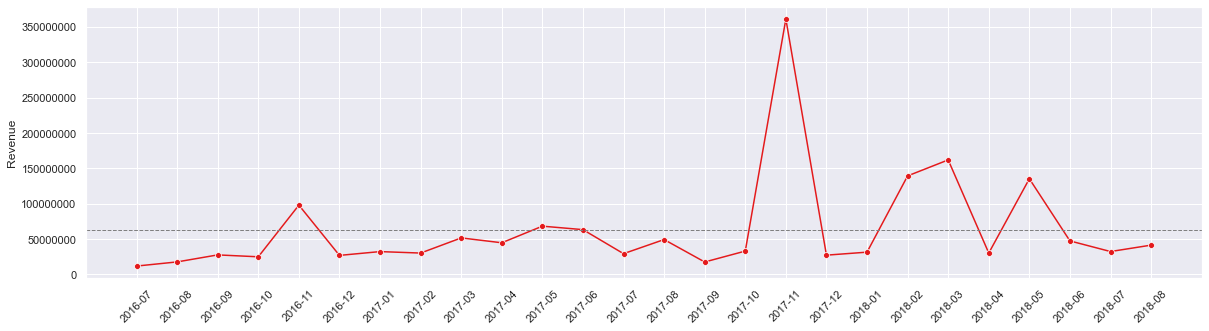

In [62]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=revenue, x="Year_Month", y="grand_total",marker="o")
plt.axhline(y=avg_revenue, c="gray", ls="--", lw=1)
ax.yaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_xlabel("")
ax.set_ylabel("Revenue")
plt.xticks(rotation=45);

<div class="alert alert-success">
2. 統計每月份平均客單價
</div>

In [64]:
# 篩選訂單狀態是 completed 的訂單按照年月計算每個月份的訂單數量
orders = order_completed.groupby("Year_Month")["increment_id"].nunique().reset_index()
revenue["total_order"] = orders["increment_id"]
revenue["AOV"] = revenue["grand_total"]/revenue["total_order"]
avg_aov = round(revenue["AOV"].mean(),2)
print(f"平均客單價：{avg_aov}")
revenue[["Year_Month","grand_total","total_order","AOV"]].head()

平均客單價：7879.84


,Year_Month,grand_total,total_order,AOV
0,2016-07,11720820.27,4930,2377.45
1,2016-08,17588479.23,6467,2719.73
2,2016-09,27503668.06,7035,3909.55
3,2016-10,24824142.90,6304,3937.84
4,2016-11,97895239.77,30544,3205.06


<div class="alert alert-warning">
<b>Insight 2.</b><br>
<br>
每個月的客單價有上升的趨勢，對照月營收並沒有成正比，接下來需觀察訂單數量的走勢是否有同步提高。
</div>

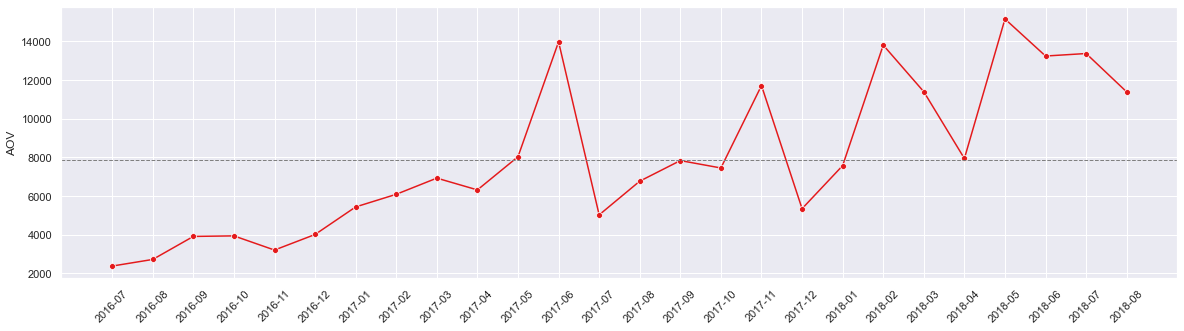

In [65]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=revenue, x="Year_Month", y="AOV",marker="o")
plt.axhline(y=avg_aov, c="gray", ls="--", lw=1)
ax.set_xlabel("")
ax.set_ylabel("AOV")
plt.xticks(rotation=45);

<div class="alert alert-success">
3. 統計每月份顧客購買頻次（平均顧客訂單數）
</div>

In [66]:
# 篩選訂單狀態是 completed 的訂單按照年月計算每個月份的顧客數量
customer_id_count = order_completed.groupby(["Year_Month"])["Customer ID"].nunique().reset_index()
customer_id_count["total_monthly_order"] = orders["increment_id"]
customer_id_count["average_monthly_order"] = round(customer_id_count["total_monthly_order"]/customer_id_count["Customer ID"],2)
avg_amo = round(customer_id_count["average_monthly_order"].mean(),2)
print(f"平均顧客訂單數：{avg_amo}")
customer_id_count.head()

平均顧客訂單數：1.74


,Year_Month,Customer ID,total_monthly_order,average_monthly_order
0,2016-07,1622,4930,3.04
1,2016-08,2640,6467,2.45
2,2016-09,3772,7035,1.87
3,2016-10,2765,6304,2.28
4,2016-11,12811,30544,2.38


<div class="alert alert-warning">
<b>Insight 3.</b><br>
<br>
通常顧客購買頻率越高，代表他們忠誠度可能也越高，或是會固定回購某些商品。可以觀察到頻次從2017年開始，除了部分月份有超過均值之外，其餘下滑到約1.5，可推測有非常高比例的客人只購買一次，需再針對這樣的狀況設計回購方案，提醒他們回來逛甚至下單。
</div>

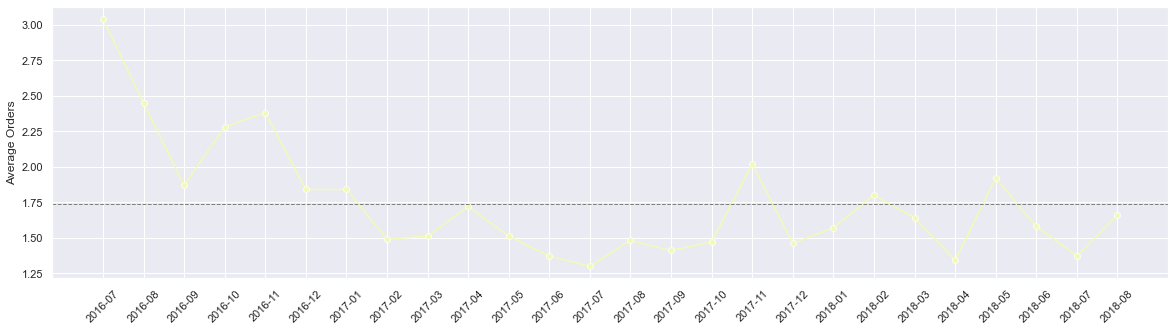

In [67]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=customer_id_count, x="Year_Month", y="average_monthly_order",marker="o")
plt.axhline(y=avg_amo, c="gray", ls="--", lw=1)
ax.set_xlabel("")
ax.set_ylabel("Average Orders")
plt.xticks(rotation=45);

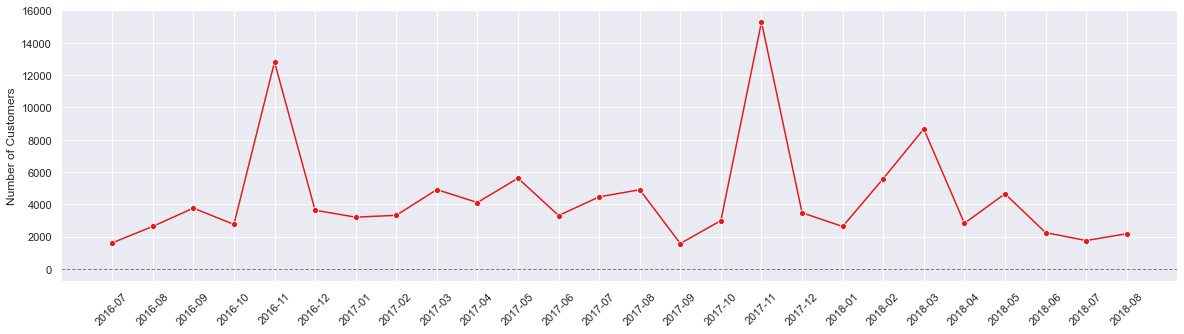

In [68]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=customer_id_count, x="Year_Month", y="Customer ID",marker="o")
plt.axhline(y=avg_amo, c="gray", ls="--", lw=1)
ax.set_xlabel("")
ax.set_ylabel("Number of Customers")
plt.xticks(rotation=45);

<div class="alert alert-success">
4. 統計顧客訂單數比例(購買1次 vs 購買2次以上)
</div>

In [69]:
number_of_orders = order_completed.groupby("Customer ID")["increment_id"].nunique().reset_index()
one = len(number_of_orders[number_of_orders["increment_id"]==1])
more = len(number_of_orders[number_of_orders["increment_id"]!=1])
data = {"Order": ["One Order", "More than One Order"], "Customer_Counts": [one, more], "%":[one/(one+more),more/(one+more)]}
order_counts = pd.DataFrame.from_dict(data)
order_counts

,Order,Customer_Counts,%
0,One Order,51801,0.65
1,More than One Order,28320,0.35


<div class="alert alert-warning">
<b>Insight 4.</b><br>
<br>
接續第3點分析顧客在資料區間內平均購買次數各自占的比例，發現僅有35%的客人購買超過2次，符合上述所推測的狀況。
</div>

<div class="alert alert-success">
5. 統計每月新舊客的人數和各自的營收貢獻<br>
新舊客定義為第一次購買為新客，若客人首購後並且當月份有回購的話則歸類為新客。
</div>

In [70]:
#找出每個客人首購的訂單時間
iffirst_perchase = order_completed.groupby("Customer ID")["created_at_date"].agg("min").reset_index()
iffirst_perchase.columns = ["Customer ID","first_perchase"]
iffirst_perchase = pd.merge(order_completed, iffirst_perchase, on="Customer ID", how="left")
#iffirst_perchase = iffirst_perchase[iffirst_perchase["status"] == "completed"]

#計算每個客人當月購買的次數
# buy_count = iffirst_perchase.groupby(["Customer ID","Year_Month"])["first_perchase"].agg("count").reset_index()
# buy_count.columns =["Customer ID","Year_Month","buy_count"]
# iffirst_perchase = pd.merge(iffirst_perchase, buy_count, on=["Customer ID","Year_Month"], how="left")
iffirst_perchase.head()

,Year_Month,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Year,Month,Customer ID,Day,created_at_date,first_perchase
0,2016-07,211131.0,completed,2016-07-01,kreations_YI 06-L,1950.00,1,1950.00,100147443,Women's Fashion,0.00,cod,2016,07,1,01,2016-07-01,2016-07-01
1,2016-07,211135.0,completed,2016-07-01,kcc_krone deal,360.00,1,60.00,100147446,Beauty & Grooming,300.00,cod,2016,07,4,01,2016-07-01,2016-07-01
2,2016-07,211138.0,completed,2016-07-01,kcc_krone deal,360.00,1,60.00,100147449,Beauty & Grooming,300.00,cod,2016,07,7,01,2016-07-01,2016-07-01
3,2016-07,211139.0,completed,2016-07-01,UK_Namkino Mix Nimco 400 Gms,170.00,1,170.00,100147450,Soghaat,0.00,cod,2016,07,6,01,2016-07-01,2016-07-01
4,2016-07,211142.0,completed,2016-07-01,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.00,1,5500.00,100147453,Appliances,0.00,cod,2016,07,9,01,2016-07-01,2016-07-01


In [71]:
#依照首購時間判斷是否為新舊客
def ifReturn(creat_d, first_d):
    if creat_d > first_d:
        if creat_d.month == first_d.month:
            return "new_customer"
        else:
            return "return_customer"
    else:
        return "new_customer"

iffirst_perchase["new_return"] = iffirst_perchase.apply(lambda x: ifReturn(x["created_at_date"],x["first_perchase"]),axis=1)

In [72]:
iffirst_perchase.head(3)

,Year_Month,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Year,Month,Customer ID,Day,created_at_date,first_perchase,new_return
0,2016-07,211131.0,completed,2016-07-01,kreations_YI 06-L,1950.00,1,1950.00,100147443,Women's Fashion,0.00,cod,2016,07,1,01,2016-07-01,2016-07-01,new_customer
1,2016-07,211135.0,completed,2016-07-01,kcc_krone deal,360.00,1,60.00,100147446,Beauty & Grooming,300.00,cod,2016,07,4,01,2016-07-01,2016-07-01,new_customer
2,2016-07,211138.0,completed,2016-07-01,kcc_krone deal,360.00,1,60.00,100147449,Beauty & Grooming,300.00,cod,2016,07,7,01,2016-07-01,2016-07-01,new_customer


In [73]:
#統計每月新舊客的人數、比例、訂單數、消費金額和客單價
new_return_G = iffirst_perchase.groupby(["Year_Month","new_return"])["grand_total"].agg("sum").reset_index()
new_return_O = iffirst_perchase.groupby(["Year_Month","new_return"])["increment_id"].nunique().reset_index()
new_return_C = iffirst_perchase.groupby(["Year_Month","new_return"])["Customer ID"].nunique().reset_index()
new_return_C
monthly_total_C = new_return_C.groupby("Year_Month")["Customer ID"].agg("sum").reset_index()
monthly_total_C.columns = ["Year_Month","total_customer"]

new_return_T = pd.merge(new_return_C,new_return_G,how="left")
new_return_T = pd.merge(new_return_T,new_return_O,how="left")
new_return_T = pd.merge(new_return_T,monthly_total_C,on="Year_Month",how="left")
new_return_T["new_return_ratio"] = round(new_return_T["Customer ID"]/new_return_T["total_customer"],2)
new_return_T["new_return_AOV"] = round(new_return_T["grand_total"]/new_return_T["increment_id"],2)
new_return_T.head()

,Year_Month,new_return,Customer ID,grand_total,increment_id,total_customer,new_return_ratio,new_return_AOV
0,2016-07,new_customer,1622,11720820.27,4930,1622,1.00,2377.45
1,2016-08,new_customer,2322,13510017.13,3243,2640,0.88,4165.90
2,2016-08,return_customer,318,4078462.10,3224,2640,0.12,1265.03
3,2016-09,new_customer,3227,21148930.95,4388,3772,0.86,4819.72
4,2016-09,return_customer,545,6354737.11,2647,3772,0.14,2400.73


In [74]:
new_return_T.groupby("new_return")["new_return_AOV"].agg("mean")

new_return
new_customer      8279.42
return_customer   7759.86
Name: new_return_AOV, dtype: float64

<div class="alert alert-warning">
<b>Insight 5.</b><br>
<br>
將銷售數據區分為新舊客後可以觀察到：<br>
• 近兩年每個月份新客族群的比例皆高於舊客，營收的成長幅度主要仰賴新客，舊客的消費金額大致來說並沒有明顯的提升。<br>
• 新舊客兩者的客單價沒有相差太大，需進一步分析顧客主要購買的產品為何。<br>
• 每月的用戶數量並沒有隨時間增加，加上第4點提到65%的客人只購買1次，代表大活動仍有一定的成效，吸引到的客人前來購買，可是後續回購表現不佳。另外觀察到2018年開始出現新舊客人數減少的現象，因為資料集缺少行銷活動做比對，本次目標將著重在不同客群的消費行為，接下來會分析銷售產品的排名，鞏固、提升現有用戶的回購。<br>
</div>

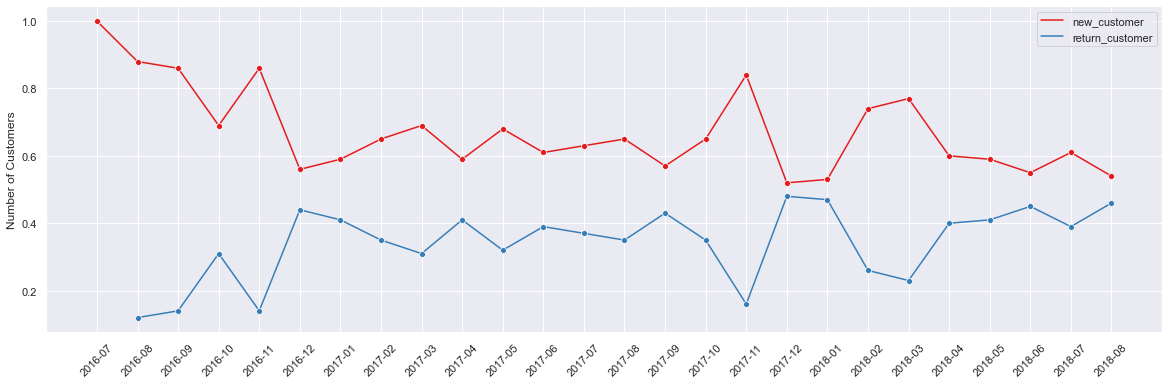

In [75]:
#每月新舊客的人數比例
fig, ax = plt.subplots(figsize=(20, 6))
sns.set(style="darkgrid",palette="Set1")
sns.lineplot(data=new_return_T, x="Year_Month", y="new_return_ratio", hue = "new_return", marker= "o")
ax.set_xlabel("")
ax.set_ylabel("Number of Customers")
ax.xaxis.set_tick_params(rotation=45)
plt.legend();

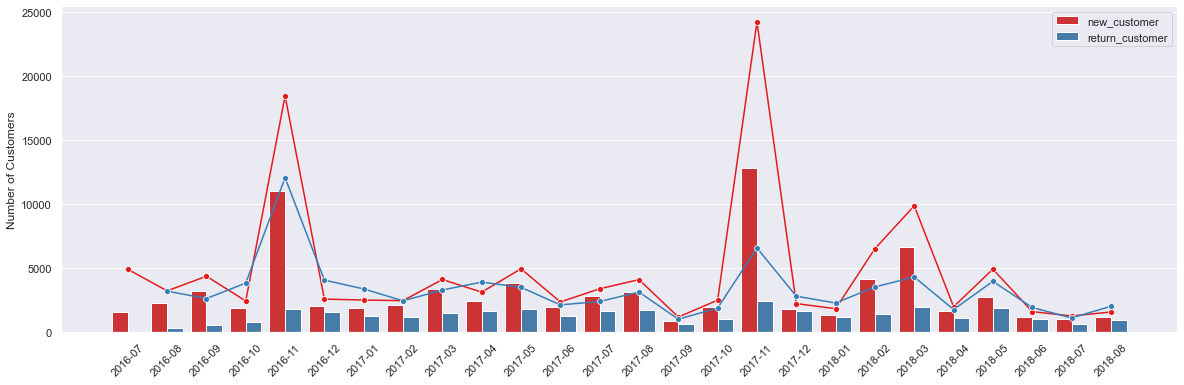

In [76]:
#每月新舊客的人數和訂單數
fig, ax = plt.subplots(figsize=(20, 6))
sns.set(style="darkgrid",palette="Set1")
sns.barplot(data=new_return_T, x="Year_Month", y="Customer ID", hue = "new_return")
sns.lineplot(data=new_return_T, x="Year_Month", y="increment_id", hue = "new_return", marker= "o",legend=False)
ax.set_xlabel("")
ax.set_ylabel("Number of Customers")
# ax2 = ax.twinx()
# ax2.set_ylabel("Number of Orders")
ax.yaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_tick_params(rotation=45)
plt.legend();

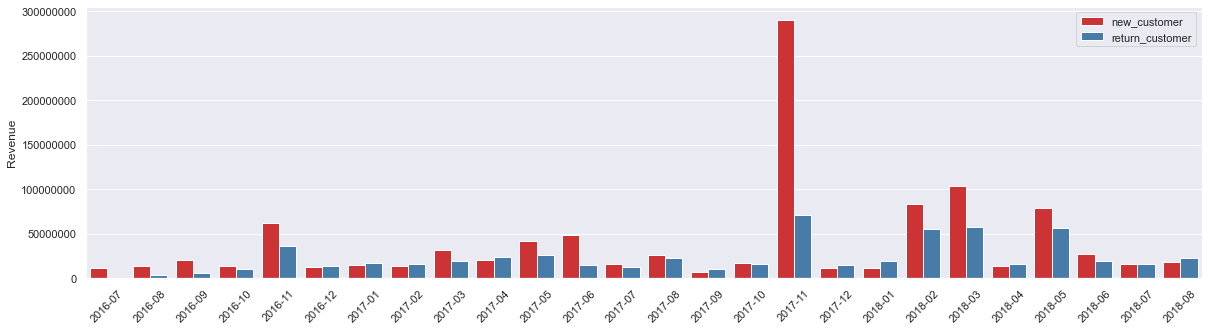

In [79]:
#每月新舊客消費金額
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid",palette="Set1")
sns.barplot(data=new_return_T, x="Year_Month", y="grand_total", hue = "new_return")
#sns.barplot(data=dt_temR, x="Year_Month", y="grand_total")
ax.set_xlabel("")
ax.set_ylabel("Revenue")
ax.yaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_tick_params(rotation=45)
plt.legend();

<div class="alert alert-success">
6. 計算每個月的回購率
(當月回購人數 / 當月所有購買人數)
</div>

In [80]:
# 使用樞紐計算所有客人在每個月份的消費次數
purchase_time = order_completed.pivot_table(index="Customer ID",columns="Year_Month",values="increment_id",aggfunc="nunique",fill_value=0)
purchase_time.head()

Year_Month,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,20,17,30,62,19,5,16,20,9,...,10,1,1,2,0,0,0,0,0,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# 當月加下個月的消費次數大於1，則代表該顧客有回購
pivot_purchase = purchase_time.applymap(lambda x:1 if x>0 else 0)
pivot_repurchase = (pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_repurchase = pivot_repurchase.shift(1,axis=1).fillna(0)
repurchase_rate = pivot_repurchase.sum()/pivot_purchase.sum()
repurchase_rate = repurchase_rate.reset_index(name = "repurchase_rate")
avg_repurchase_rateround = round(repurchase_rate["repurchase_rate"].mean(),3)
print(f"平均回購率：{avg_repurchase_rateround}")

平均回購率：0.155


<div class="alert alert-warning">
<b>Insight 6. </b><br>
<br>
回購週期以1個月做計算，平均回購率為15.5%，大節日的月份回購率表現較差，原因在於新客人數提升了，但舊客沒有同步增加。<br>
接下來進一步搭配RFM模型觀察消費族群的購買狀況。
</div>

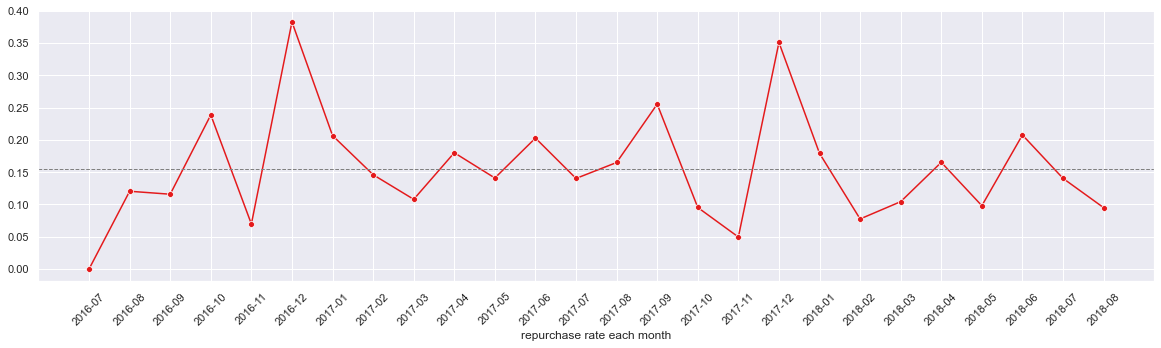

In [82]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=repurchase_rate, x="Year_Month", y="repurchase_rate",marker="o")
plt.axhline(y=avg_repurchase_rateround, c="gray", ls="--", lw=1)
ax.set_xlabel("repurchase rate each month")
ax.set_ylabel("")
plt.xticks(rotation=45);

<div class="alert alert-success">
7. 使用RFM模型將顧客分類成不同客群<br>
• 最近一次消費（Recency）。顧客上次消費時間愈近，價值愈大。<br>
• 消費頻率（Frequency）。顧客在一個月或一年中，買了多少次東西？購買頻率愈高，用戶價值愈大。<br>
• 消費金額（Monetary）。顧客一共在產品上花了多少錢？創造了多少利潤？消費金額愈高，用戶價值愈大。<br>
</div>

In [83]:
#把 reference_date 設定在顧客最後消費的3天後
reference_date = dt["created_at_date"].max() + datetime.timedelta(days=3)
print(f"Set the reference date as {reference_date}")

Set the reference date as 2018-08-31 00:00:00


In [84]:
rfm_dt = order_completed.groupby("Customer ID").agg \
    ({"created_at_date" : lambda created_at_date :(reference_date - created_at_date.max()).days,  # Recency
      "increment_id" : lambda increment_id: increment_id.nunique(),  # Frequency
      "grand_total":  lambda grand_total: grand_total.sum()}).reset_index().sort_values(by="Customer ID")    # Monetary

In [85]:
rfm_dt.head()

,Customer ID,created_at_date,increment_id,grand_total
0,1,791,1,1950.00
1,3,469,1,4980.00
2,4,4,236,1316173.25
3,6,791,1,170.00
4,7,503,4,105.00


In [86]:
#把欄位重新命名為 Recency, Frequency, Monetary
rfm_dt.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary
0,1,791,1,1950.00
1,3,469,1,4980.00
2,4,4,236,1316173.25
3,6,791,1,170.00
4,7,503,4,105.00


In [87]:
#R、F、M每一個維度劃分1~5分，5分代表最高分。
# Recency指標數字越小表示客戶近期剛購買，因此Recency越低則可得到更高分(5分)。
# Frequency和Monetary指標的表示客戶購買頻繁並且消費更多的金額，因此Frequency和Monetary值越高可得到更高分(5分)。
rfm_dt["Recency_Score"]  = pd.qcut(rfm_dt['Recency'], 5, [5, 4, 3, 2, 1])
rfm_dt["Frequency_Score"]  = pd.qcut(rfm_dt['Frequency'].rank(method="first"),  5, [1, 2, 3, 4, 5])
rfm_dt["Monetary_Score"]  = pd.qcut(rfm_dt['Monetary'], 5, [1, 2, 3, 4, 5])

In [88]:
rfm_dt["RFM_SCORE"] = (rfm_dt["Recency_Score"].astype(str) + rfm_dt["Frequency_Score"].astype(str) + rfm_dt["Monetary_Score"].astype(str))
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE
0,1,791,1,1950.00,1,1,2,112
1,3,469,1,4980.00,2,1,3,213
2,4,4,236,1316173.25,5,5,5,555
3,6,791,1,170.00,1,1,1,111
4,7,503,4,105.00,2,5,1,251


<div class="alert alert-success">
在第5點有提到這次的行銷目標：鞏固、提升回購人數。<br>
在電商零售產業，平台透過行銷活動培養消費者每個月有固定搜尋和購買的習慣，因為回購不強調客人要買花多少錢(即Monetary)，更重視他有較高的 Recency_Score 和 Frequency_Score，這兩個分數比起 Monetary_Score 更重要。<br>
因此，接下來我們使用 Recency_Score 和 Frequency_Score 來把顧客分群。
</div>

<img src ="https://github.com/LiangYuDer/E-commerce-Analysis/blob/main/Recency%20and%20Frequency%20Grid.JPG?raw=true" width = "750" height ="410" >

In [89]:
#1. Champions VIP顧客
#2. Loyal Customers 忠實顧客
#3. Potential Loyalists 潛在的忠誠顧客
#4. New Customers 新顧客
#5. Promising 有希望的顧客
#6. Need Attention 需要關注的顧客
#7. About to Sleep 快睡著(流失)的顧客
#8. Can't Lose Them 不能失去的顧客
#9. At Risk 有風險的顧客
#10. Hibernating 冬眠(流失)的顧客

seg_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][3-4]": "At Risk",
    r"[1-2]5": "Can't Lose Them",
    r"3[1-2]": "About To Sleep",
    r"33": "Need Attention",
    r"[3-4][4-5]": "Loyal Customers",
    r"41": "Promising",
    r"51": "New Customers",
    r"[4-5][2-3]": "Potential Loyalists",
    r"5[4-5]": "Champions"
}

In [90]:
rfm_dt["Segment"] = rfm_dt["Recency_Score"].astype(str) + rfm_dt["Frequency_Score"].astype(str)
rfm_dt["Segment"] = rfm_dt["Segment"].replace(seg_map, regex=True)
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE,Segment
0,1,791,1,1950.00,1,1,2,112,Hibernating
1,3,469,1,4980.00,2,1,3,213,Hibernating
2,4,4,236,1316173.25,5,5,5,555,Champions
3,6,791,1,170.00,1,1,1,111,Hibernating
4,7,503,4,105.00,2,5,1,251,Can't Lose Them


In [91]:
#統計每個分組的顧客人數、消費金額和比例
rfm_dt_segnum = rfm_dt.groupby("Segment").agg({"Customer ID":"count","Monetary":["sum","mean"]}).reset_index()
rfm_dt_segnum = rfm_dt_segnum.droplevel(0, axis=1)
rfm_dt_segnum["ratio_segment"] = 100*(rfm_dt_segnum["count"] / rfm_dt_segnum["count"].sum())
rfm_dt_segnum["ratio_monetary"] = 100*(rfm_dt_segnum["sum"] / rfm_dt_segnum["sum"].sum())
rfm_dt_segnum.columns = ["Segment", "Customer Number","Monetary","avg_monetary","ratio_segment","ratio_monetary"]
rfm_dt_segnum.sort_values("Customer Number", ascending=False)

,Segment,Customer Number,Monetary,avg_monetary,ratio_segment,ratio_monetary
4,Hibernating,23565,159229683.02,6757.04,29.41,9.76
8,Potential Loyalists,14508,114342741.45,7881.36,18.11,7.01
5,Loyal Customers,12434,521854253.52,41969.94,15.52,31.97
3,Champions,11146,602843538.77,54086.09,13.91,36.94
0,About To Sleep,7931,44579705.29,5620.94,9.90,2.73
1,At Risk,4653,46382796.45,9968.36,5.81,2.84
2,Can't Lose Them,3815,126687454.44,33207.72,4.76,7.76
6,Need Attention,1918,14831329.15,7732.71,2.39,0.91
9,Promising,82,680461.35,8298.31,0.10,0.04
7,New Customers,69,678801.09,9837.70,0.09,0.04


<div class="alert alert-warning">
<b>Insight 7. </b><br>
<br>
• 核心顧客(Champions、Loyal Customers、Potential Loyalists)：近期剛買完且消費頻率屬中上，針對高活躍的核心顧客，建議可以根據常買的商品推出「定期購服務」，或是「個性化推薦」的訊息作為互動方式。<br>
• 新顧客(New Customers)：因為消費者最近剛完成購買，短時間內不一定會有回購需求，為了提升新客的黏著度變成核心客群，可以在策略上以「建立與顧客的接觸點」，讓客人可以透過社群接收到產品資訊、會員活動等。<br>
• 久沒來的老顧客(Can't Lose Them)：曾經消費頻率高的顧客，但已經有段時間沒來消費了，這群客人的溝通成本較低，可以利用補貨提醒的方式搭配相關折價券，觀察回購成果，因為不希望讓他們變成流失客群，後續可以針對沒回購的客人了解不回購的原因。<br>
• 冬眠(流失)的顧客(Hibernating)：距上次消費間隔已久且消費頻率最低，可視為「一次性消費者」。可以先了解顧客在過往購物體驗上是否遇到不滿的狀況，建議提供較高的折扣重新邀請顧客使用優化後的服務。<br>
</div>

In [92]:
#利用 treemap 呈現每個分組的顧客數量
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
fig = px.treemap(rfm_dt_segnum, path=['Segment'],values='Customer Number', width=800, height=400)
fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=10, l=20, r=20, b=10))
fig.show()

In [93]:
rfm_dt[["Segment","Recency", "Frequency", "Monetary"]].groupby("Segment").agg("mean")

,Recency,Frequency,Monetary
Segment,,,
About To Sleep,348.39,1.00,5620.94
At Risk,583.89,2.03,9968.36
Can't Lose Them,562.63,7.68,33207.72
Champions,86.20,5.57,54086.09
Hibernating,598.35,1.00,6757.04
Loyal Customers,277.38,4.66,41969.94
Need Attention,283.76,1.00,7732.71
New Customers,104.35,1.00,9837.70
Potential Loyalists,200.67,1.00,7881.36


<div class="alert alert-success">
8. 統計最有價值顧客購買的產品和消費總金額
</div>

In [94]:
rfm_dt_mapping = rfm_dt[["Customer ID","Segment"]]
dt_rfm = dt.merge(rfm_dt_mapping,how="left")
dt_rfm_champ =dt_rfm[(dt_rfm["status"] == "completed") & (dt_rfm["Segment"] == "Champions")].groupby("category_name_1")["grand_total"].agg(["count","sum"]).reset_index()
dt_rfm_champ.sort_values(by="sum", ascending=False)

,category_name_1,count,sum
9,Mobiles & Tablets,15227,218141664.23
0,Appliances,9426,106733401.86
4,Entertainment,4502,81876816.60
14,Women's Fashion,11096,43833354.33
13,Superstore,13288,31763279.03
3,Computing,2287,23105740.16
8,Men's Fashion,11945,21257698.73
1,Beauty & Grooming,8470,16529698.62
6,Home & Living,5047,14345832.34
10,Others,3012,14269108.84


<div class="alert alert-warning">
<b>Insight 8. </b><br>
<br>
• 分群結果可發現VIP顧客的人數比例為13.91%、銷售金額占36.94%，最近購買距今天數(Recency)平均多達86.2天，以電商的角度看回購週期其實蠻高的，而且其他分群的天數甚至更高，因此針對「降低回購天數」會是接下來訂定策略著重的方向。<br>
• 為了更解客人的購買輪廓，可以跟顧客常買的產品類型、是否使用促銷優惠券等數據交叉比對。例如VIP顧客主要購買了手機和平板電腦、家電、娛樂產品、女裝服飾等，女性產品高於男性產品。<br>
• 因為手機、家電回購週期較長，後續就可以從相關的產品主題中推薦給顧客，中高價位的像是電腦椅、手機殼等3C周邊，低單價的商品則可選服飾相關，測試應用在不同客群的效果。<br>
</div> 

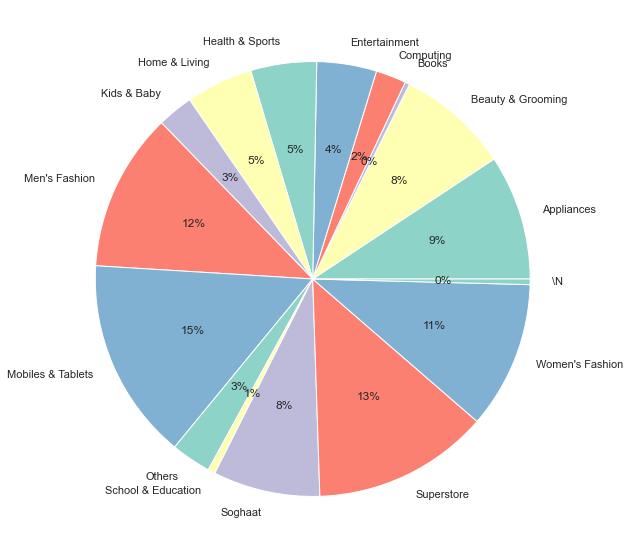

In [95]:
#8-1 最有價值顧客購買的商品圓餅圖
fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette("Set3")[0:5]
plt.pie(dt_rfm_champ["count"], labels = dt_rfm_champ["category_name_1"], colors=colors, autopct='%.0f%%')
plt.show()

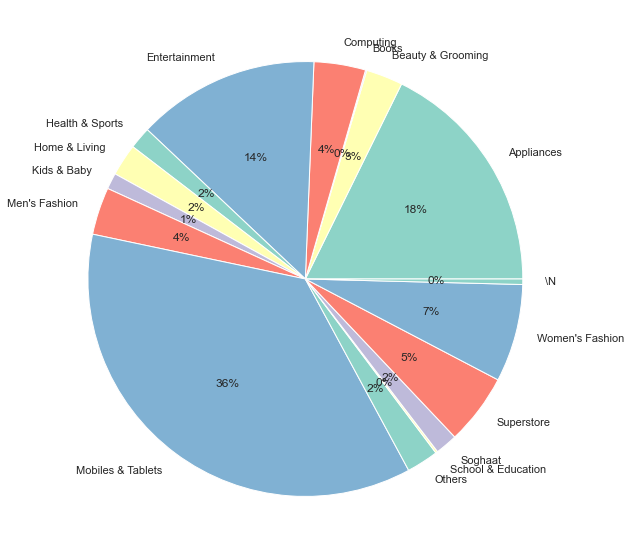

In [96]:
#8-2 最有價值顧客購買商品的消費總金額圓餅圖
fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette("Set3")[0:5]
plt.pie(dt_rfm_champ["sum"], labels = dt_rfm_champ["category_name_1"], colors=colors, autopct='%.0f%%')
plt.show()

In [97]:
order_completed.to_csv("order_completed.csv", index=False)